In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
sns.set()

In [2]:
# Import data
data = pd.read_csv(r'C:\Users\blake\Documents\Springboard\Github\Capstone2\Covid_Final\Capstone_2_Covid_TimeSeries\data\raw\may-us-counties.csv', index_col='date', parse_dates=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2502832 entries, 2020-01-21 to 2022-05-13
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   county  object 
 1   state   object 
 2   fips    float64
 3   cases   int64  
 4   deaths  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 114.6+ MB


Data is initailly segmented on a county level, will need to be grouped and then filtered by state for analysis.

### Examine Data

In [6]:
data.describe()

,fips,cases,deaths
count,2.479154e+06,2.502832e+06,2.445227e+06
mean,3.139958e+04,1.003380e+04,1.616100e+02
std,1.634251e+04,4.752522e+04,8.203335e+02
min,1.001000e+03,0.000000e+00,0.000000e+00
25%,1.902300e+04,3.820000e+02,6.000000e+00
50%,3.001100e+04,1.773000e+03,3.300000e+01
75%,4.611100e+04,5.884000e+03,1.010000e+02
max,7.803000e+04,2.908425e+06,4.026700e+04


#### Check for missing values

In [7]:
data.isna().sum()

county        0
state         0
fips      23678
cases         0
deaths    57605
dtype: int64

In [8]:
# Examine NA values for deaths
na_deaths = data.loc[data.deaths.isna()]
na_deaths.state.value_counts()

Puerto Rico    57605
Name: state, dtype: int64

All the NA values for deaths come from Pureto Rico. These NA value will be filled in with 0.

After looking at the Puerto Rico data more closely, it seems they counted covid cases and deaths cumulatively first by the entire island, then on 2020-05-05 they switched to counting by county. This won't affect my analysis since I will be grouping values by date for modeling, so I don't really care about the county distinction.

In [9]:
data['deaths'].fillna(0, inplace=True)
data.isna().sum()

county        0
state         0
fips      23678
cases         0
deaths        0
dtype: int64

In [10]:
# Examine NA values for fips
na_fips = data.loc[data.fips.isna()]
na_fips.county.value_counts()

Unknown          21401
New York City      804
Kansas City        785
Joplin             688
Name: county, dtype: int64

In [11]:
unknown_fips = na_fips.loc[na_fips.county=='Unknown']
unknown_fips.describe()

,fips,cases,deaths
count,0.0,21401.000000,21401.000000
mean,NaN,4795.763189,149.001402
std,NaN,15090.090288,589.585606
min,NaN,0.000000,0.000000
25%,NaN,16.000000,0.000000
50%,NaN,569.000000,4.000000
75%,NaN,2985.000000,36.000000
max,NaN,370566.000000,11799.000000


The unknown counties don't seem to be a problem. The values for cases and deaths seem reasonable.

In [12]:
for i in ['New York City', 'Kansas City', 'Joplin']:
    print('{} count: {}'.format(i, len(data.loc[data.county==i])))

New York City count: 804
Kansas City count: 785
Joplin count: 688


Since the total number of entries in the data for the above three cities is equal to the number of missin fips value for each of them, its safe to say that the fips codes for these three counties were never provided for some reason.

In [13]:
na_fips.loc[na_fips.county!='Unknown'].describe()

,fips,cases,deaths
count,0.0,2.277000e+03,2277.000000
mean,NaN,3.286680e+05,10322.650417
std,NaN,5.874767e+05,14550.647069
min,NaN,1.000000e+00,0.000000
25%,NaN,7.535000e+03,109.000000
50%,NaN,4.399000e+04,575.000000
75%,NaN,2.607620e+05,23949.000000
max,NaN,2.422658e+06,40267.000000


The values for these entries are very high, higher on average than the rest of the data. This is because New York is included in the data, since New York got hit the hardest in the US. Based on this, these values seems fine to keep.

## Cleaning and Preporcessing

In [14]:
# Remove unecissary columns
data.drop(columns=['county', 'fips'], inplace=True)

In [15]:
# Group data by date and state
state_data = data.groupby(['date', 'state'])[['cases', 'deaths']].sum()
state_data.reset_index(level='state', inplace=True)

Now that we have the cumulative case and death counts by day, we need to take the difference between days to get the daily change.

In [16]:
state_data.head()

,state,cases,deaths
date,,,
2020-01-21,Washington,1,0.0
2020-01-22,Washington,1,0.0
2020-01-23,Washington,1,0.0
2020-01-24,Illinois,1,0.0
2020-01-24,Washington,1,0.0


For this project I will be focussing on data for the state of california exclusively

In [17]:
ca_data = state_data.loc[state_data.state=='California', :]
ca_data['new_cases'] = ca_data['cases'].diff().fillna(1)
ca_data['pct_change'] = ca_data['cases'].pct_change(periods=1)
ca_data.shape

(840, 5)

Finaly a rolling window will be used to calculate the 7 day average for daily new cases. The average will be caluculted with each record being the center of its calculation. I will also set the minimun number of periods for a calcultion to 4 so that there is no data loss.

Using the seven day average will smooth out the time series, removing some of the excess noise.

In [18]:
# Smooth data using rolling window to get seven day average
ca_data['seven_day_ave'] = ca_data['new_cases'].rolling(7, min_periods=4, center=True).mean()
ca_data.shape

(840, 6)

In [19]:
ca_data.head(), ca_data.tail()

(                 state  cases  deaths  new_cases  pct_change  seven_day_ave
 date                                                                       
 2020-01-25  California      1     0.0        1.0         NaN       0.500000
 2020-01-26  California      2     0.0        1.0         1.0       0.400000
 2020-01-27  California      2     0.0        0.0         0.0       0.333333
 2020-01-28  California      2     0.0        0.0         0.0       0.428571
 2020-01-29  California      2     0.0        0.0         0.0       0.285714,
                  state    cases   deaths  new_cases  pct_change  seven_day_ave
 date                                                                          
 2022-05-09  California  9297615  90712.0     7060.0    0.000760    8700.000000
 2022-05-10  California  9322169  90822.0    24554.0    0.002641    8728.285714
 2022-05-11  California  9325522  90804.0     3353.0    0.000360   10179.166667
 2022-05-12  California  9329044  90818.0     3522.0    0.00

## Visualize Data

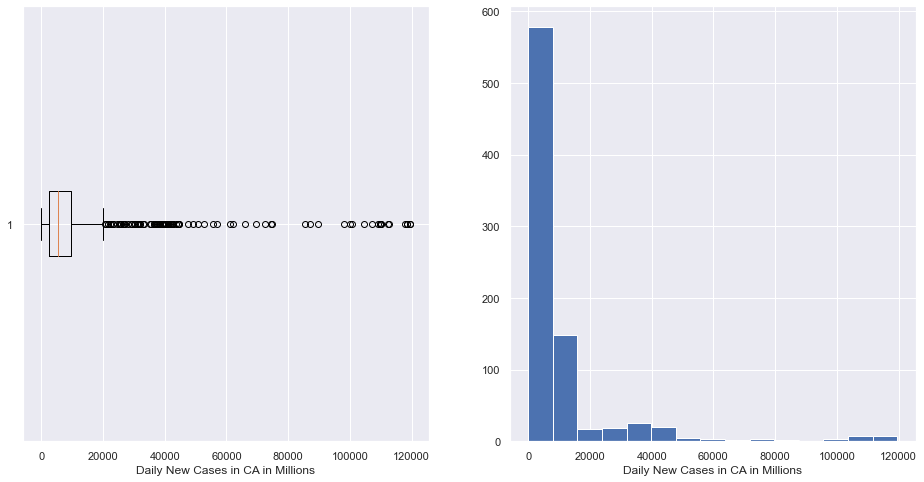

In [20]:
# Create boxplot and histogram for new case distributions
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].boxplot(x=ca_data.seven_day_ave, vert=False)
ax[0].set_xlabel('Daily New Cases in CA in Millions')
ax[1].hist(x=ca_data.seven_day_ave, bins=15)
ax[1].set_xlabel('Daily New Cases in CA in Millions')
plt.show()

The data is not normaly distributed, and appears to be heavily skewed to the right. This shouldn't be a problem since neither of the models I will be using require the data to normaly distributed.

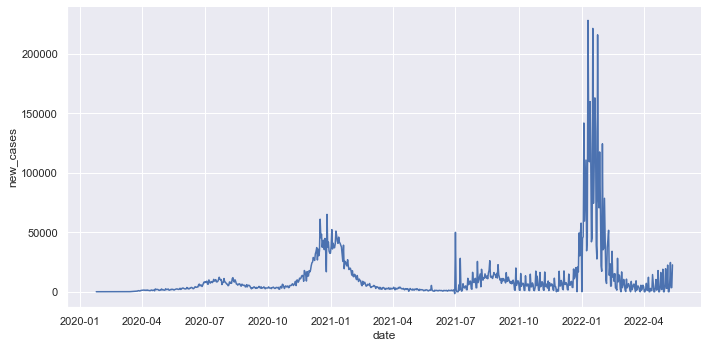

In [21]:
sns.relplot(kind='line', data=ca_data, x=ca_data.index, y='new_cases', aspect=2)

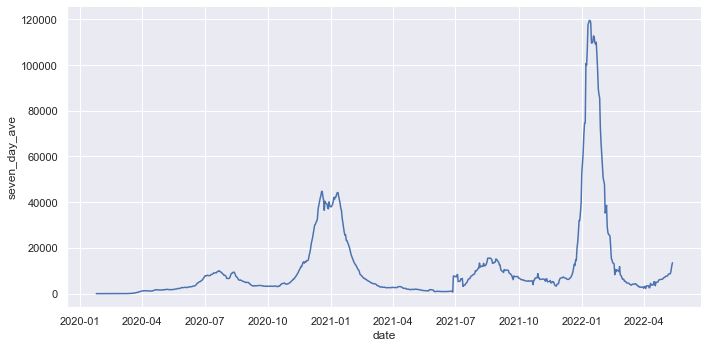

In [22]:
sns.relplot(kind='line', data=ca_data, x=ca_data.index, y='seven_day_ave', aspect=2)

In [24]:
ca_data.to_csv(r'C:\Users\blake\Documents\Springboard\Github\Capstone2\Covid_Final\Capstone_2_Covid_TimeSeries\data\cleaned\may_Wrangled_CA.csv')

# Import Hospitalization Data

In [3]:
hospital_data = pd.read_csv(r'C:\Users\blake\Documents\Springboard\Github\Capstone2\Covid_Final\Capstone_2_Covid_TimeSeries\data\raw\Hospital_data.csv')

In [4]:
# Remove unnecissary columns from hospital data and isolate CA info
hospital_data = hospital_data[['collection_week', 'state', 'inpatient_beds_7_day_avg', 'inpatient_beds_used_7_day_avg', 'inpatient_beds_used_covid_7_day_avg']]
hospital_ca = hospital_data.loc[hospital_data.state=='CA']

In [5]:
hospital_ca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24754 entries, 56 to 345770
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   collection_week                      24754 non-null  object 
 1   state                                24754 non-null  object 
 2   inpatient_beds_7_day_avg             24748 non-null  float64
 3   inpatient_beds_used_7_day_avg        24748 non-null  float64
 4   inpatient_beds_used_covid_7_day_avg  24741 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.1+ MB


In [28]:
hospital_ca.describe()

,inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,inpatient_beds_used_covid_7_day_avg
count,24748.000000,24748.000000,24741.000000
mean,-2535.535744,-33611.836904,-222609.353773
std,51971.305838,180586.892859,416026.485598
min,-999999.000000,-999999.000000,-999999.000000
25%,54.600000,38.300000,0.000000
50%,133.900000,98.900000,7.400000
75%,246.000000,188.000000,20.100000
max,1172.300000,857.600000,1297.700000


In [29]:
hospital_ca.head()

,collection_week,state,inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,inpatient_beds_used_covid_7_day_avg
56,2021-07-02,CA,10.0,-999999.0,NaN
61,2021-06-18,CA,10.0,-999999.0,NaN
164,2021-02-05,CA,7.0,-999999.0,0.0
178,2021-01-22,CA,34.0,19.7,0.0
179,2021-01-22,CA,58.0,52.4,0.0


The data source indicates that values of -999999 are used for any averages lower than 4. I will replace these values with 0.

In [30]:
hospital_ca.replace(to_replace={-999999:0}, inplace=True)

In [31]:
# Check na values
hospital_ca.loc[hospital_ca.inpatient_beds_7_day_avg.isna(), :]

,collection_week,state,inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,inpatient_beds_used_covid_7_day_avg
326064,2020-08-21,CA,NaN,NaN,0.0
327294,2020-08-28,CA,NaN,NaN,0.0
337116,2020-08-14,CA,NaN,NaN,0.0
343199,2020-07-31,CA,NaN,NaN,0.0
344098,2020-08-07,CA,NaN,NaN,0.0
345304,2020-08-07,CA,NaN,NaN,0.0


There are a total of 6 records with missing values for inpatient bed availability and occupancy, I will remove these values

In [32]:
hospital_ca.loc[hospital_ca.inpatient_beds_used_covid_7_day_avg.isna(), :]

,collection_week,state,inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,inpatient_beds_used_covid_7_day_avg
56,2021-07-02,CA,10.0,0.0,NaN
61,2021-06-18,CA,10.0,0.0,NaN
198,2020-12-04,CA,0.0,0.0,NaN
201,2020-11-27,CA,0.0,0.0,NaN
205,2020-11-20,CA,0.0,0.0,NaN
208,2020-11-06,CA,0.0,0.0,NaN
88987,2021-07-09,CA,10.0,0.0,NaN
93286,2021-07-23,CA,10.0,0.0,NaN
95752,2021-07-16,CA,10.0,5.0,NaN
102306,2021-06-25,CA,10.0,4.2,NaN


It looks like most of the missing values for covid occupancy are tied to records where total occupancy is zero. For those records I will set covid occupancy to zero, I will drop the remaining 5.

In [33]:
hospital_ca.loc[(hospital_ca.inpatient_beds_used_covid_7_day_avg.isna()) & (~hospital_ca.inpatient_beds_7_day_avg.isna()), 'inpatient_beds_used_covid_7_day_avg'] = 0

In [34]:
# Drop all remaing NA values
hospital_ca.dropna(inplace=True)

In [35]:
hospital_ca = hospital_ca.groupby('collection_week').sum()
hospital_ca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 2020-07-31 to 2021-11-26
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   inpatient_beds_7_day_avg             70 non-null     float64
 1   inpatient_beds_used_7_day_avg        70 non-null     float64
 2   inpatient_beds_used_covid_7_day_avg  70 non-null     float64
dtypes: float64(3)
memory usage: 2.2+ KB


In [36]:
# Rename columns for clarity
hospital_ca.rename(columns={'inpatient_beds_7_day_avg':'bed_availability', 'inpatient_beds_used_7_day_avg':'total_occupancy', 'inpatient_beds_used_covid_7_day_avg':'covid_occupancy'}, inplace=True)

# Add ratios for general and covid occupancy
hospital_ca['covid_rato'] = hospital_ca.covid_occupancy / hospital_ca.bed_availability
hospital_ca['total_ratio'] = hospital_ca.total_occupancy / hospital_ca.bed_availability

In [37]:
hospital_ca.fillna(value=0, inplace=True)

In [38]:
hospital_ca.sort_values(by='collection_week', inplace=True)

In [39]:
hospital_ca.head(), hospital_ca.tail()

(                 bed_availability  total_occupancy  covid_occupancy  \
 collection_week                                                       
 2020-07-31                60201.6          42903.1           7462.9   
 2020-08-07                59538.2          42066.2           6655.3   
 2020-08-14                60508.3          43090.1           6261.2   
 2020-08-21                60925.3          42931.7           5554.5   
 2020-08-28                60667.6          42253.6           4689.8   
 
                  covid_rato  total_ratio  
 collection_week                           
 2020-07-31         0.123965     0.712657  
 2020-08-07         0.111782     0.706541  
 2020-08-14         0.103477     0.712135  
 2020-08-21         0.091169     0.704661  
 2020-08-28         0.077303     0.696477  ,
                  bed_availability  total_occupancy  covid_occupancy  \
 collection_week                                                       
 2021-10-29                60332.6       

In [40]:
ca_data.tail()

,state,cases,deaths,new_cases,pct_change,seven_day_ave
date,,,,,,
2022-05-09,California,9297615,90712.0,7060.0,0.000760,8700.000000
2022-05-10,California,9322169,90822.0,24554.0,0.002641,8728.285714
2022-05-11,California,9325522,90804.0,3353.0,0.000360,10179.166667
2022-05-12,California,9329044,90818.0,3522.0,0.000378,12215.000000
2022-05-13,California,9351630,90959.0,22586.0,0.002421,13503.750000


## Resample the covid infection data on weekly basis to match hospital data for modeling

In [41]:
covid_ca_resample = ca_data.loc['2020-07-31':]
covid_ca_resample = covid_ca_resample.resample(rule='W-FRI', convention='start').mean()

In [42]:
covid_ca_resample.head(), covid_ca_resample.tail()

(                    cases        deaths    new_cases  pct_change  \
 date                                                               
 2020-07-31  502273.000000   9222.000000  8004.000000    0.016194   
 2020-08-07  528124.000000   9719.571429  6552.714286    0.012564   
 2020-08-14  584471.285714  10675.285714  9300.142857    0.016165   
 2020-08-21  640873.285714  11543.142857  6678.285714    0.010552   
 2020-08-28  681827.428571  12432.428571  5485.714286    0.008112   
 
             seven_day_ave  
 date                       
 2020-07-31    7876.000000  
 2020-08-07    6890.755102  
 2020-08-14    8984.734694  
 2020-08-21    6714.857143  
 2020-08-28    5526.142857  ,
                    cases        deaths    new_cases  pct_change  seven_day_ave
 date                                                                          
 2022-04-15  9.140139e+06  89541.714286  3774.857143    0.000413    3546.367347
 2022-04-22  9.170375e+06  89872.857143  4970.285714    0.000542    484

In [43]:
covid_ca_resample.drop(index='2021-12-03', inplace=True)

In [44]:
covid_ca_resample.to_csv(r'C:\Users\blake\Documents\Springboard\Github\Capstone2\Covid_Final\Capstone_2_Covid_TimeSeries\data\cleaned\Wrangled_CA_resample.csv')
hospital_ca.to_csv(r'C:\Users\blake\Documents\Springboard\Github\Capstone2\Covid_Final\Capstone_2_Covid_TimeSeries\data\cleaned\Wrangled_CA_hospitals.csv')